<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-10/LR_with_propensity_score_buckets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will try to do multiple linear regressions with each different buckets of propensity score. This is to find out how different groups of counties respond to the COVID 19.

# 1. load data.

In [ ]:
cd drive/My\ Drive/fall

/content/drive/My Drive/fall


In [ ]:
ls

counties_with_diff_and_all_covariates.csv
counties_with_diff.csv
county_data_with_covariates.csv
county_data_with_reduced_covariates_more_variables.csv
county_data_with_reduced_covariates_with_SIP.csv
county_data_with_reduced_covariates_with_SIP_up_to_5.csv
county_data_with_reduced_covariates_with_SIP_up_to_8.csv
LR_with_propensity_score_buckets.ipynb
more_mutual_info.ipynb
PSM_new.ipynb
standardized_linear_regression.ipynb
what_make_people_change_behavior.ipynb


In [ ]:
import pandas as pd
import numpy as np

In [51]:
data = pd.read_csv('county_data_with_reduced_covariates_with_SIP.csv')

In [ ]:
data.head()

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9


In [52]:
data.dropna(inplace = True)

In [ ]:
print(f"after dropping this dataset has {data.shape[0]} records.")

after dropping this dataset has 2995 records.


# 2. PSM

In [ ]:
%load_ext rpy2.ipython
# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
%%R
# install standard propensity matching library in R 
install.packages("MatchIt")
# load MatchIt package
library(MatchIt)
# install Coarsened Exact Matching package
install.packages('cem')
library(cem)
# install optimal match package
install.packages('optmatch')
library(optmatch)


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/MatchIt_3.0.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 317607 bytes (310 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[writ

In [53]:
# rename data to dataframe
dataframe = data

In [54]:
# -i means pass in some argument/data from python world to R world
%%R -i dataframe

# using MatchIt package to do PSM - guess it used logistic regression?

m.out <- matchit(SIP.~Median.Household.Income + X..Rural +
                 political_diff+
                 X..Asian + X..Black + 
                 X..Non.Hispanic.White +
                 X..Hispanic + Population_y,
                 method = "full", data = dataframe) 

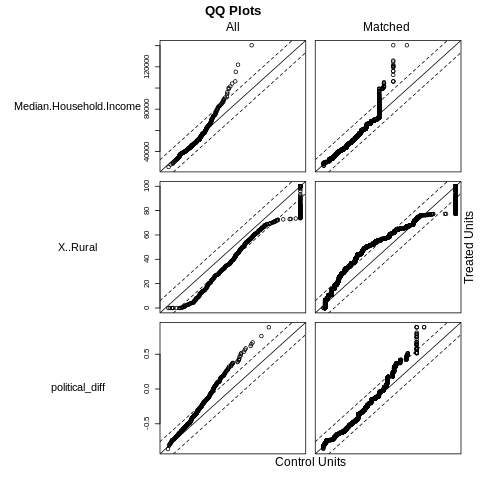

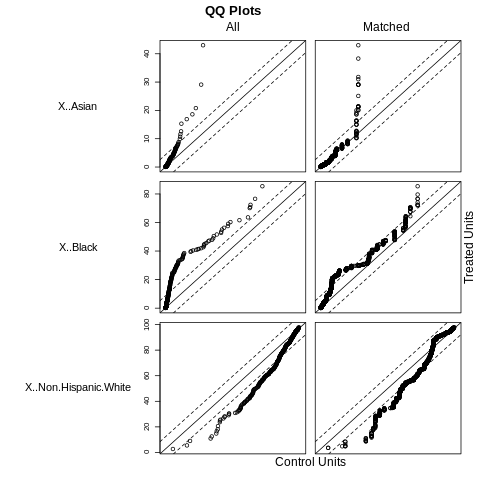

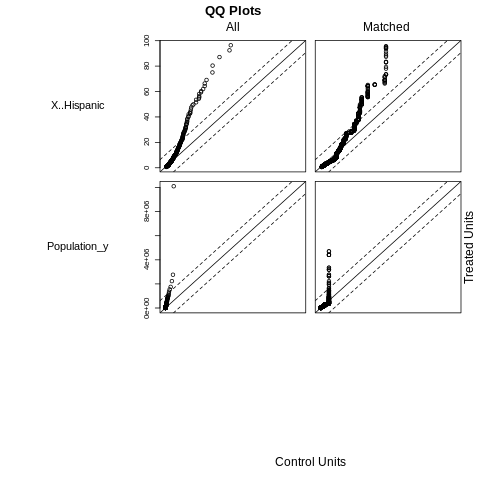

In [ ]:
# to see how maching it doing by visualizing distributions
%%R
plot(m.out)

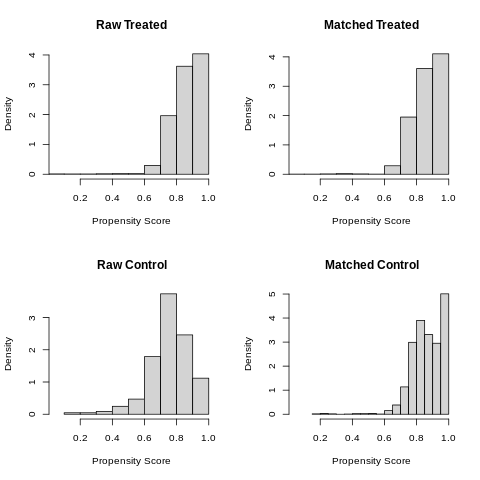

In [ ]:
%%R
plot(m.out, type = 'hist')

[1] "To identify the units, use first mouse button; to stop, use second."
integer(0)


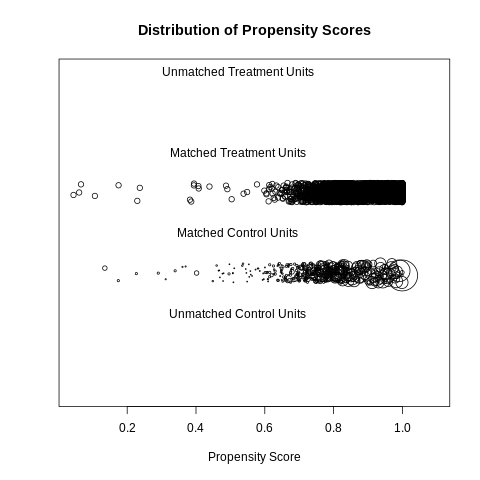

In [ ]:
%%R
plot(m.out, type='jitter')

In [ ]:
%%R
summary(m.out, standardize=T)


Call:
matchit(formula = SIP. ~ Median.Household.Income + X..Rural + 
    political_diff + X..Asian + X..Black + X..Non.Hispanic.White + 
    X..Hispanic + Population_y, data = dataframe, method = "full")

Summary of balance for all data:
                        Means Treated Means Control Std. Mean Diff. eCDF Med
distance                       0.8676        0.7547          1.1147   0.2988
Median.Household.Income    52991.1876    52921.7584          0.0048   0.0480
X..Rural                      55.2676       64.5125         -0.2978   0.0949
political_diff                -0.2877       -0.4283          0.4492   0.1485
X..Asian                       1.6851        0.9888          0.2323   0.0254
X..Black                      10.2542        4.0293          0.4151   0.0954
X..Non.Hispanic.White         74.8670       82.4000         -0.3679   0.1090
X..Hispanic                   10.2487        6.5177          0.2534   0.0696
Population_y              123128.3980    30946.6018          0.2511 

In [153]:
%%R
# extract matched data.
matched_data <- match.data(m.out)

In [154]:
# import dataframe from R to python.... since I am not familar with manipulating
# R objects 
matched_data = %R matched_data

In [57]:
no_SIP_diff = np.average(matched_data[matched_data['SIP.'] == 0]['diff_in_perc_at_home'], weights = matched_data[matched_data['SIP.'] == 0]['weights'])

In [58]:
SIP_diff = np.average(matched_data[matched_data['SIP.'] == 1]['diff_in_perc_at_home'], weights = matched_data[matched_data['SIP.'] == 1]['weights'])

In [59]:
SIP_diff

0.03318145620033819

In [ ]:
no_SIP_diff

0.02198215399177096

In [ ]:
SIP_diff - no_SIP_diff

0.011199302208567227

In [ ]:
matched_data

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,distance,weights,subclass
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,0.840166,1.000000,1.0
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,0.960092,1.000000,107.0
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,0.971925,1.000000,389.0
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,0.859824,1.000000,86.0
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,0.840270,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,0.669064,0.058477,359.0
2992,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,0.797502,1.000000,382.0
2993,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,0.662699,0.175432,224.0
2994,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,0.679251,0.701727,145.0


Seems like distance column is the propensity score we want because you can find out [here](https://cran.r-project.org/web/packages/MatchIt/MatchIt.pdf) that without specifying any distance metric the default distance is "logit", which I think is the propensity score we are using.

In [ ]:
# max propensity score
matched_data['distance'].max()

0.9999999999999998

In [ ]:
matched_data[matched_data['distance'] == matched_data['distance'].max()]

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,distance,weights,subclass
89,4.0,AZ,Arizona,Maricopa County,4013.0,0.070350,1,65234.0,2.4,4410824,-0.034465,23.9,15.2,4.6,5.5,31.3,54.9,1.0,1.0,88.0
189,6.0,CA,California,Los Angeles County,6037.0,0.118096,1,67986.0,0.6,10105518,0.480185,21.7,13.6,15.4,8.0,48.6,26.1,1.0,1.0,88.0
200,6.0,CA,California,Orange County,6059.0,0.159275,1,89373.0,0.1,3185968,0.076800,21.9,14.8,21.4,1.6,34.2,40.1,1.0,1.0,88.0
203,6.0,CA,California,Riverside County,6065.0,0.091735,1,66793.0,4.6,2450758,0.043345,25.1,14.4,7.1,6.2,49.6,34.7,1.0,1.0,88.0
207,6.0,CA,California,San Diego County,6073.0,0.128628,1,78777.0,3.3,3343364,0.178358,21.6,14.0,12.6,4.7,34.0,45.2,1.0,1.0,88.0
339,12.0,FL,Florida,Miami-Dade County,12086.0,0.156587,1,52043.0,0.4,2761581,0.295646,20.2,16.2,1.7,15.6,69.1,13.0,1.0,1.0,88.0
579,17.0,IL,Illinois,Cook County,17031.0,0.123588,1,63347.0,0.0,5180493,0.529565,21.8,14.6,7.9,23.0,25.5,42.1,1.0,1.0,153.0
1769,36.0,NY,New York,Kings County,36047.0,0.173891,1,60862.0,0.0,2582830,0.618298,22.8,13.9,12.7,29.9,19.1,36.4,1.0,1.0,88.0
2454,48.0,TX,Texas,Dallas County,48113.0,0.078694,1,59838.0,0.7,2637772,0.262413,26.1,10.7,6.7,22.6,40.5,28.6,1.0,1.0,88.0
2497,48.0,TX,Texas,Harris County,48201.0,0.090368,1,60241.0,1.2,4698619,0.123964,26.6,10.5,7.4,18.8,43.3,29.1,1.0,1.0,88.0


In [ ]:
# minimum propensity score
matched_data['distance'].min()

0.0439668014865062

In [ ]:
matched_data[matched_data['distance'] == matched_data['distance'].min()]

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,distance,weights,subclass
77,2.0,AK,Alaska,Northwest Arctic Borough,2188.0,0.063479,1,59337.0,57.5,7671,-0.151711,35.3,7.3,0.8,1.1,3.8,10.9,0.043967,1.0,189.0


# 3. standardize data

In [ ]:
# import packages from LR and standardize tool
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [155]:
matched_data.drop(['SIP.'], axis=1, inplace = True) # drops SIP? column because we are grouping by propsensity score

In [156]:
# get only numeric columns because we can't scale the strings, etc.
matched_data = matched_data._get_numeric_data()

In [157]:
matched_data

,state,county_code,diff_in_perc_at_home,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,distance,weights,subclass
0,1.0,1001.0,0.050678,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,0.840166,1.000000,1.0
1,1.0,1003.0,0.050312,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,0.960092,1.000000,107.0
2,1.0,1005.0,0.007037,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,0.971925,1.000000,389.0
3,1.0,1007.0,0.011809,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,0.859824,1.000000,86.0
4,1.0,1009.0,0.038890,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,0.840270,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,56.0,56037.0,-0.018485,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,0.669064,0.058477,359.0
2992,56.0,56039.0,0.075183,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,0.797502,1.000000,382.0
2993,56.0,56041.0,0.010157,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,0.662699,0.175432,224.0
2994,56.0,56043.0,-0.007825,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,0.679251,0.701727,145.0


Notice that we have state and county_code, which are not our covariates. I include them here to see the random covariate's coefficients in linear model

In [90]:
scaler = StandardScaler()

In [195]:
# I here choose not to standardize all variables except
# the response variable and propensity score
X = matched_data.drop(['distance', 'diff_in_perc_at_home'], axis = 1)
data_scaled = scaler.fit_transform(X)

In [196]:
df_scaled = pd.DataFrame(data = data_scaled, columns = X.columns)

In [197]:
df_scaled

,state,county_code,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,weights,subclass
0,-1.932273,-1.936635,0.453803,-0.473902,-0.157728,-0.610061,0.477626,-0.769688,-0.135252,0.690378,-0.482907,-0.085113,0.000000,-1.455608
1,-1.932273,-1.936503,0.328881,-0.464196,0.318721,-0.882412,-0.151938,0.303254,-0.135252,-0.036346,-0.367446,0.357734,0.000000,-0.539526
2,-1.932273,-1.936371,-1.327667,0.360832,-0.247843,0.828138,-0.361793,0.079724,-0.383615,2.676756,-0.389095,-1.529399,0.000000,1.897596
3,-1.932273,-1.936239,-0.493754,0.380245,-0.255121,-0.808907,-0.481710,-0.568511,-0.490056,0.814959,-0.511773,-0.070016,0.000000,-0.721014
4,-1.932273,-1.936107,-0.183374,1.079092,-0.151161,-1.655997,0.327730,-0.188511,-0.454575,-0.541592,-0.006631,0.548964,0.000000,-1.455608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,1.700926,1.694401,1.451544,-1.480112,-0.194543,-0.743143,1.227108,-1.552041,-0.206213,-0.569277,0.462430,0.166505,-1.131341,1.638328
2991,1.700926,1.694533,3.291264,-0.331544,-0.253123,1.925692,-1.111275,-0.814394,-0.064291,-0.603883,0.375834,0.277216,0.000000,1.837100
2992,1.700926,1.694665,0.743839,-0.438312,-0.261284,-1.003927,2.006568,-1.104982,-0.383615,-0.596962,-0.035496,0.574125,-0.990808,0.471620
2993,1.700926,1.694797,0.157701,-0.668026,-0.297700,-1.087367,0.177834,0.593842,-0.277173,-0.610804,0.318103,0.322508,-0.358407,-0.211120


In [198]:
df_distance_and_response = matched_data[['distance', 'diff_in_perc_at_home']]

In [199]:
df_distance_and_response

,distance,diff_in_perc_at_home
0,0.840166,0.050678
1,0.960092,0.050312
2,0.971925,0.007037
3,0.859824,0.011809
4,0.840270,0.038890
...,...,...
2991,0.669064,-0.018485
2992,0.797502,0.075183
2993,0.662699,0.010157
2994,0.679251,-0.007825


In [201]:
df_scaled.index.values[0]

0

In [200]:
df_distance_and_response.index.values[0]

'0'

In [202]:
df_distance_and_response = df_distance_and_response.reset_index()

In [203]:
df_scaled.index.values[0]

0

In [204]:
df_distance_and_response.index.values[0]

0

In [205]:
df_scaled['distance'] = df_distance_and_response['distance']
df_scaled['diff_in_perc_at_home'] = df_distance_and_response['diff_in_perc_at_home']

In [206]:
df_scaled

,state,county_code,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,weights,subclass,distance,diff_in_perc_at_home
0,-1.932273,-1.936635,0.453803,-0.473902,-0.157728,-0.610061,0.477626,-0.769688,-0.135252,0.690378,-0.482907,-0.085113,0.000000,-1.455608,0.840166,0.050678
1,-1.932273,-1.936503,0.328881,-0.464196,0.318721,-0.882412,-0.151938,0.303254,-0.135252,-0.036346,-0.367446,0.357734,0.000000,-0.539526,0.960092,0.050312
2,-1.932273,-1.936371,-1.327667,0.360832,-0.247843,0.828138,-0.361793,0.079724,-0.383615,2.676756,-0.389095,-1.529399,0.000000,1.897596,0.971925,0.007037
3,-1.932273,-1.936239,-0.493754,0.380245,-0.255121,-0.808907,-0.481710,-0.568511,-0.490056,0.814959,-0.511773,-0.070016,0.000000,-0.721014,0.859824,0.011809
4,-1.932273,-1.936107,-0.183374,1.079092,-0.151161,-1.655997,0.327730,-0.188511,-0.454575,-0.541592,-0.006631,0.548964,0.000000,-1.455608,0.840270,0.038890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,1.700926,1.694401,1.451544,-1.480112,-0.194543,-0.743143,1.227108,-1.552041,-0.206213,-0.569277,0.462430,0.166505,-1.131341,1.638328,0.669064,-0.018485
2991,1.700926,1.694533,3.291264,-0.331544,-0.253123,1.925692,-1.111275,-0.814394,-0.064291,-0.603883,0.375834,0.277216,0.000000,1.837100,0.797502,0.075183
2992,1.700926,1.694665,0.743839,-0.438312,-0.261284,-1.003927,2.006568,-1.104982,-0.383615,-0.596962,-0.035496,0.574125,-0.990808,0.471620,0.662699,0.010157
2993,1.700926,1.694797,0.157701,-0.668026,-0.297700,-1.087367,0.177834,0.593842,-0.277173,-0.610804,0.318103,0.322508,-0.358407,-0.211120,0.679251,-0.007825


# 4. create bins of propensity scores

So let's divide dataset into 4 bins of propensity scores, and do linear regression on each of those 4 bins `(0 - 0.25, 0.25 - 0.5, 0.5 - 0.75, 0.75 - 1)` based on the percentile of propensity score (distance).

In [217]:
# using qcut here to split data points evenly between 4 buckets
propensity_buckets = pd.qcut(df_scaled['distance'], 4)

In [218]:
df_scaled['propensity_bucket'] = propensity_buckets

In [219]:
df_scaled.head()

,state,county_code,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,weights,subclass,distance,diff_in_perc_at_home,propensity_bucket
0,-1.932273,-1.936635,0.453803,-0.473902,-0.157728,-0.610061,0.477626,-0.769688,-0.135252,0.690378,-0.482907,-0.085113,0.0,-1.455608,0.840166,0.050678,"(0.787, 0.852]"
1,-1.932273,-1.936503,0.328881,-0.464196,0.318721,-0.882412,-0.151938,0.303254,-0.135252,-0.036346,-0.367446,0.357734,0.0,-0.539526,0.960092,0.050312,"(0.941, 1.0]"
2,-1.932273,-1.936371,-1.327667,0.360832,-0.247843,0.828138,-0.361793,0.079724,-0.383615,2.676756,-0.389095,-1.529399,0.0,1.897596,0.971925,0.007037,"(0.941, 1.0]"
3,-1.932273,-1.936239,-0.493754,0.380245,-0.255121,-0.808907,-0.481710,-0.568511,-0.490056,0.814959,-0.511773,-0.070016,0.0,-0.721014,0.859824,0.011809,"(0.852, 0.941]"
4,-1.932273,-1.936107,-0.183374,1.079092,-0.151161,-1.655997,0.327730,-0.188511,-0.454575,-0.541592,-0.006631,0.548964,0.0,-1.455608,0.840270,0.038890,"(0.787, 0.852]"


# 5. linear regression in each bucket

In [220]:
df_scaled['propensity_bucket'].unique()

[(0.787, 0.852], (0.941, 1.0], (0.852, 0.941], (0.043, 0.787]]
Categories (4, interval[float64]): [(0.043, 0.787] < (0.787, 0.852] < (0.852, 0.941] < (0.941, 1.0]]

In [211]:
regressor = LinearRegression()

In [231]:
# linear regression on each bin
for bin in df_scaled['propensity_bucket'].unique():
  data_in_this_bin = df_scaled[df_scaled['propensity_bucket'] == bin]
  X = data_in_this_bin[['state', 'county_code']]
  y = data_in_this_bin['diff_in_perc_at_home']
  num_of_data_points = data_in_this_bin.shape[0]
  print(f'propensity score from {bin.left} to {bin.right} has {num_of_data_points} data points')
  regressor.fit(X, y)
  for i, coef in enumerate(regressor.coef_):
    print(f'after standardization, feature {X.columns[i]}\' coefficient is {coef} in this bucket')
  print()

propensity score from 0.787 to 0.852 has 749 data points
after standardization, feature state' coefficient is -0.04535849601836687 in this bucket
after standardization, feature county_code' coefficient is 0.04421541414170534 in this bucket

propensity score from 0.941 to 1.0 has 749 data points
after standardization, feature state' coefficient is 0.777000908965698 in this bucket
after standardization, feature county_code' coefficient is -0.7756038844127016 in this bucket

propensity score from 0.852 to 0.941 has 748 data points
after standardization, feature state' coefficient is -0.006166743278021632 in this bucket
after standardization, feature county_code' coefficient is 0.008490259759059789 in this bucket

propensity score from 0.043 to 0.787 has 749 data points
after standardization, feature state' coefficient is -0.7761830810713736 in this bucket
after standardization, feature county_code' coefficient is 0.7737836817867325 in this bucket



In [233]:
# linear regression on each bin
for bin in sorted(df_scaled['propensity_bucket'].unique()):
  data_in_this_bin = df_scaled[df_scaled['propensity_bucket'] == bin]
  X = data_in_this_bin.drop(['diff_in_perc_at_home', 'weights', 'subclass', \
                             'distance', 'propensity_bucket', 'county_code', 'state'], axis = 1)
  y = data_in_this_bin['diff_in_perc_at_home']
  num_of_data_points = data_in_this_bin.shape[0]
  print(f'propensity score from {bin.left} to {bin.right} has {num_of_data_points} data points')
  regressor.fit(X, y)
  for i, coef in enumerate(regressor.coef_):
    print(f'after standardization, feature {X.columns[i]}\' coefficient is {coef} in this bucket')
  print()

propensity score from 0.043 to 0.787 has 749 data points
after standardization, feature Median.Household.Income' coefficient is 0.019036559133832894 in this bucket
after standardization, feature X..Rural' coefficient is 0.0029020779778359466 in this bucket
after standardization, feature Population_y' coefficient is 0.15674954763345625 in this bucket
after standardization, feature political_diff' coefficient is 0.007470591145639958 in this bucket
after standardization, feature X..less.than.18.years.of.age' coefficient is 0.0011952049451218905 in this bucket
after standardization, feature X..65.and.over' coefficient is 0.004251281169884684 in this bucket
after standardization, feature X..Asian' coefficient is -0.002946011830434324 in this bucket
after standardization, feature X..Black' coefficient is 0.026294746964371483 in this bucket
after standardization, feature X..Hispanic' coefficient is 0.001380476047640414 in this bucket
after standardization, feature X..Non.Hispanic.White' coeff

Don't know if this is so interpretable? One thing that stands out is population's importance in the first quantile is 0.15, that is quite big comparing to other effects

In [238]:
# linear regression on each bin
for bin in sorted(df_scaled['propensity_bucket'].unique()):
  data_in_this_bin = df_scaled[df_scaled['propensity_bucket'] == bin]
  X = data_in_this_bin.drop(['diff_in_perc_at_home', 'weights', 'subclass', \
                             'distance', 'propensity_bucket', 'county_code', 'state'], axis = 1)
  y = data_in_this_bin['diff_in_perc_at_home']
  r_2 = 0

  print(f'propensity score from {bin.left} to {bin.right}\'s increasing of R^2 summary')
  for i, column in enumerate(X.columns):
    regressor = LinearRegression().fit(X.iloc[:,:i+1], y) # get the first i columns of X
    r_2_new = regressor.score(X.iloc[:,:i+1], y) # the new R^2 we get by including one more covariate
    print(f'including column {column} increase R^2 by {r_2_new - r_2}')
    r_2 = r_2_new
  print()

propensity score from 0.043 to 0.787's increasing of R^2 summary
including column Median.Household.Income increase R^2 by 0.3295103886341669
including column X..Rural increase R^2 by 0.0032321684249939087
including column Population_y increase R^2 by 0.04186754942991944
including column political_diff increase R^2 by 0.005351732455498304
including column X..less.than.18.years.of.age increase R^2 by 0.0062489724857447415
including column X..65.and.over increase R^2 by 0.0016370980555237558
including column X..Asian increase R^2 by 0.0019289951308053555
including column X..Black increase R^2 by 0.010850167139631162
including column X..Hispanic increase R^2 by 0.0005363374135169963
including column X..Non.Hispanic.White increase R^2 by 0.001851170381331091

propensity score from 0.787 to 0.852's increasing of R^2 summary
including column Median.Household.Income increase R^2 by 0.48140610738702905
including column X..Rural increase R^2 by 3.560304725036545e-06
including column Population_y